# Телеком — Определение неэффективных операторов

Задача поставлена продуктовым менеджером из отдел продуктовой разработки.

Сервис "Нупозвони" разрабатывает новый функционал, который будет выдавать руководителю информацию о наиболее неэффективных операторах. Неэффективными операторами считаются те, у которых большое число пропущенных входящих вызовов (внутренних и внешних), а также высокое время ожидания ответа при входящих вызовах. Также такие операторы могут совершать малое число исходящих вызовов, если оператор работает на исходящий обзвон.

Необходимо определить критерии неэффективности, выявить закономерности, проверить гипотезы. 

Выявление неэффективных сотрудников позволит увеличить ценность сервиса для клиента, а значит потенциально увеличит время жизни клиента. Так же совместно с HR будет сформирована система мотивации операторов.

### Содержание

* [Шаг 1. Изучение общей информации. Предобработка данных](#1-bullet)
* [Шаг 2.  Исследовательский анализ](#2-bullet)
* 2.1. [Количество операторов у клиентов](#2-1-bullet)
* 2.2. [Время ожидания входящих внешних вызовов. Критерий определения неэффективных операторов](#2-2-bullet)
* 2.3. [Доля пропущенных звонков по операторам. Критерий определения неэффективных операторов](#2-3-bullet)
* 2.4. [Количество исходящих звонков. Критерий определения неэффективных операторов](#2-4-bullet)
* [Шаг 3. Проверка гипотез](#3-bullet)
* 3.1. [Проверка гипотезы о различии времени ожидания ответа на входящий звонок в зависимости от тарифного плана](#3-1-bullet)
* 3.2. [Проверка гипотезы о различии числа пропущенных входящих вызовов в зависимости от тарифного плана](#3-2-bullet)
* 3.3. [Проверка гипотезы о различии числа исходящих вызовов в зависимости от тарифного плана](#3-3-bullet)
* [Шаг 4. Выводы и рекомендации](#4-bullet)

### Шаг 1. Изучение общей информации. Предобработка данных<a class="anchor" id="1-bullet"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st

In [2]:
telecom_clients = pd.read_csv('telecom_clients.csv')

In [3]:
telecom_dataset = pd.read_csv('telecom_dataset.csv')

In [4]:
telecom_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16



    
Датасет telecom_clients.csv содержит колонки:
* user_id — Идентификатор клиентского аккаунта в сервисе
* tariff_plan — Текущий тарифный план клиента
* date_start — Дата регистрации клиентв в сервисе

Отличие тарифных планов (А, В, С)
- Базовая стоимость тарифного плана A - 5000 условных единиц (у.е.)
- Базовая стоимость тарифного плана B - 2000 условных единиц (у.е.)
- Базовая стоимость тарифного плана C - 1000 условных единиц (у.е.)
- Входящие звонки на всех тарифах - бесплатные
    
Внутренние звонки на всех тарифах - бесплатные до 2000 минут разговоров в месяц, после чего
тарифицируются:
* Тарифный план A - 0.1 условных единиц за минуту
* Тарифный план B - 0.15 условных единиц за минуту
* Тарифный план C - 0.3 условных единиц за минуту
    
Исходящие (не внутренние) звонки:
* Тарифный план A - 0.4 условных единиц за минуту
* Тарифный план B - 0.5 условных единиц за минуту
* Тарифный план C - 0.7 условных единиц за минуту
    
За каждого оператора клиент платит 100 условных единиц на любом тарифе дополнительно к
базовой стоимости тарифного плана и тарификации за звонки

In [5]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB



    
* В датасете 732 строки и три колонки.
* пропущенных значений нет.
* в колонке "date_start" необходимо изменить тип данных, перевести значения из строки в дату

In [6]:
telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format='%Y-%m-%d')

In [7]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [8]:
telecom_clients.duplicated().sum()

0


    
Дупликаты в датасете telecom_clients отсутствуют

In [9]:
telecom_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25



    
Датасет telecom_dataset.csv содержит колонки:
- user_id — Идентификатор клиентского аккаунта в сервисе
- date — Дата статистики
- direction — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- internal — Является ли звонок внутренним звонком между операторами клиента
- operator_id — Идентификатор оператора
- is_missed_call — Является ли звонок пропущенным
- calls_count — Количество звонков
- call_duration — Длительность звонка (без учета времени ожидания)
- total_call_duration — Длительность звонка (с учетом времени ожидания)

In [10]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB



    
* В датасете 53902 строки и 9 колонок.
* пропущенные значения в двух колонках "internal" и "operator_id".
* в колонке "date" необходимо изменить тип данных, перевести значения из строки в дату

In [11]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date']).dt.tz_localize(None)

In [12]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns]
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB



    
    Цель проекта - определить неэффективных операторов.
    У 8172 клиентов не определены операторы. Это 15,16% от общего количества клиентов.
    Так как нет какой-либо логической возможности заменить пропущенные значения, принято решение удалить пропущенные 
    значение. Не смотря на то, что это большой объем данных.

In [13]:
telecom_dataset.dropna(subset = ['operator_id'], inplace = True)

In [14]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
user_id                45730 non-null int64
date                   45730 non-null datetime64[ns]
direction              45730 non-null object
internal               45670 non-null object
operator_id            45730 non-null float64
is_missed_call         45730 non-null bool
calls_count            45730 non-null int64
call_duration          45730 non-null int64
total_call_duration    45730 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.2+ MB



    
     Остались пропущенные значения в колонке "internal" - 60 шт., что составляет 0,13% от данных

In [15]:
telecom_dataset.query('internal.isnull()').head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1924,166406,2019-09-02,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26,in,NaN,908960.0,False,1,393,423
6216,166541,2019-09-26,in,NaN,908958.0,False,2,547,612
7528,166604,2019-11-01,in,NaN,893402.0,False,1,94,117
8650,166658,2019-09-24,in,NaN,890404.0,False,1,150,157



    
* По колонке "user_id" не удалось выявить взаимосвязи - у 30 уникальных пользователей пропущены значения, у 56,6% пользователей это единственный звонок без определения "внутренний / внешний".
* По колонке "date" не удалось выявить взаимосвязи - 36 разных дат, в которых встречается пропущенное значение. В 52,7% случаев, в этот день выявлен только 1 звонок без определения "внутренний / внешний".
* По колонке 'operator_id' не удалось выявить взаимосвязи - у 41 уникальных оператора имеются звоники, без определения "внутренний / внешний". В 68,29% случаях, у этих операторов выявлен 1 звонок без определения "внутренний / внешний"  

Все звонки с пропущенными значениями в колонке "internal" - являются входящими. Один из критериев определения неэффективных операторов является - число пропущенных вызовов. Посмотрим, сколько принятых и пропущенных звонков.

In [16]:
telecom_dataset.query('internal.isnull()')['is_missed_call'].value_counts()

False    59
True      1
Name: is_missed_call, dtype: int64

    
    59 звонков принято и всего 1 пропущенный. Так как логически эти пропуски не восстановить,
    а объем пропущенных значений составляет 0,13%, а из непринятых всего 1 звонок, было принято решение их удалить. 

In [17]:
telecom_dataset.dropna(subset = ['internal'], inplace = True)

In [18]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
user_id                45670 non-null int64
date                   45670 non-null datetime64[ns]
direction              45670 non-null object
internal               45670 non-null object
operator_id            45670 non-null float64
is_missed_call         45670 non-null bool
calls_count            45670 non-null int64
call_duration          45670 non-null int64
total_call_duration    45670 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.2+ MB


    Проверим датасет на наличие дупликатов.

In [19]:
telecom_dataset.duplicated().sum()

4179

    В датасете много дубликатов ( 9,15% от общего количества строк). В колонке ['date'] предполагалось, что будут
    указаны даты и время. Так как вместо времени везде стояло значение "00:00:00+03:00", трудно определить это 
    действительно дубликаты или аналогичные действия были совершены в один день, но в разное время. 
    Принято решение, удалить дубликаты

In [20]:
telecom_dataset.drop_duplicates().reset_index(drop = True)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-05,out,True,880022.0,True,3,0,5
1,166377,2019-08-05,out,True,880020.0,True,1,0,1
2,166377,2019-08-05,out,True,880020.0,False,1,10,18
3,166377,2019-08-05,out,False,880022.0,True,3,0,25
4,166377,2019-08-05,out,False,880020.0,False,2,3,29
...,...,...,...,...,...,...,...,...,...
41486,168606,2019-11-09,out,False,957922.0,False,4,551,593
41487,168606,2019-11-10,out,True,957922.0,False,1,0,25
41488,168606,2019-11-10,out,True,957922.0,True,1,0,38
41489,168606,2019-11-11,out,True,957922.0,False,2,479,501


**Cоздадим колонку ['waiting_time'], в которой вычислим время ожидания.**

In [21]:
telecom_dataset['waiting_time'] = telecom_dataset['total_call_duration'] - telecom_dataset['call_duration']


**Создадим столбец ['avg_wait_time_per_call'], в котором будет расчитано среднее время ожидания** 

In [22]:
telecom_dataset['avg_wait_time_per_call'] = telecom_dataset['waiting_time'] / telecom_dataset['calls_count']
telecom_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5,1.666667
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1,1.000000
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8,8.000000
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25,8.333333
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26,13.000000


In [23]:
telecom_dataset[telecom_dataset['direction'] == "in"]['avg_wait_time_per_call'].describe()

count    13953.000000
mean        16.493897
std         13.531959
min          0.000000
25%          7.666667
50%         13.000000
75%         21.432432
max        261.000000
Name: avg_wait_time_per_call, dtype: float64

   
Среднее время ожидания при звонке - 13 секунд.
    
25% пользователь ожидали не более 7,6 секунд.
    
75 % ожидали не более 21,4 секунды
    
самый большой выброс в данных - 261 секунды ( или 4,35 минуты).
    
стандартное отклонение - 13,5 секунды. Так как стандартное отклонение велико, в наборе данных могут быть серьёзные аномалии или выбросы.

  
**преобразуем категориальные переменные в двух колонках в числовые значения: False = 0, True = 1** 

In [24]:
telecom_dataset['internal'].value_counts()

False    39861
True      5809
Name: internal, dtype: int64

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder() # создаём переменную класса LabelEncoder - кодировщик
telecom_dataset['internal'] = encoder.fit_transform(telecom_dataset['internal']) # используем кодировщик, чтобы "перевести" строковые названия в числа
telecom_dataset['internal'].value_counts()

0    39861
1     5809
Name: internal, dtype: int64

In [26]:
telecom_dataset['is_missed_call'].value_counts()

False    30153
True     15517
Name: is_missed_call, dtype: int64

In [27]:
encoder =  LabelEncoder() # создаём переменную класса LabelEncoder - кодировщик
telecom_dataset['is_missed_call'] = encoder.fit_transform(telecom_dataset['is_missed_call']) # используем кодировщик, чтобы "перевести" строковые названия в числа
telecom_dataset['is_missed_call'].value_counts()

0    30153
1    15517
Name: is_missed_call, dtype: int64

### Шаг 2.  Исследовательский анализ<a class="anchor" id="2-bullet"></a>

### 2.1. Определить какое количество операторов у клиентов<a class="anchor" id="2-1-bullet"></a>

In [28]:
telecom_dataset['user_id'].nunique()

290

In [29]:
telecom_dataset['operator_id'].nunique()

1092

    В датасете 290 клиентов и 1092 оператора

In [30]:
telecom_dataset.groupby('user_id')['operator_id'].nunique().describe()

count    290.000000
mean       3.765517
std        5.717712
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       50.000000
Name: operator_id, dtype: float64


В среднем у каждого клиента по 3,77 оператора
    
Если посмотреть на медиану, то у каждого клиента по 2 оператора.
    
Стандартное отклонение - 5,71, говорит нам о наличии серьёзных аномалий или выбросах.
    
У 75% клиентов не больше 4-х операторов.
    
Максимальное значение - 50 операторов. 
    
Посмотрим на диаграмму размаха

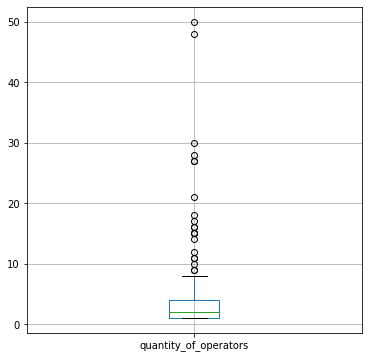

In [31]:
cnt_operators = telecom_dataset.groupby('user_id')['operator_id'].nunique().reset_index()
cnt_operators.columns = ['user_id','quantity_of_operators']
cnt_operators.boxplot(column='quantity_of_operators', figsize=(6,6))

(0, 9)

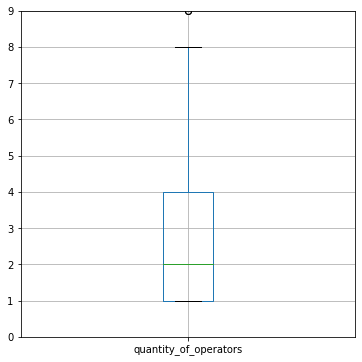

In [32]:
cnt_operators.boxplot(column='quantity_of_operators', figsize=(6,6))
plt.ylim(0,9)


    
Выбросы начинаются после 8 операторов на клиента.
    
Посмотрим показатели по очищенным от выбросов данных

In [33]:
cnt_operators_cor = cnt_operators.query('quantity_of_operators <= quantity_of_operators.quantile(0.95)')
cnt_operators_cor['quantity_of_operators'].describe()

count    275.000000
mean       2.672727
std        2.103651
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       12.000000
Name: quantity_of_operators, dtype: float64

Text(0.5, 1.0, 'Количество операторов у клиентов')

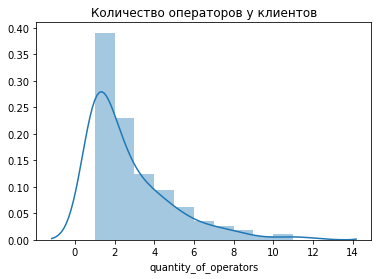

In [103]:
sns.distplot(cnt_operators_cor['quantity_of_operators'], norm_hist=True, bins = range(12), label='0')
plt.title('Количество операторов у клиентов')


По очищенным данным:
    
У большинства клиентов от 1 до 2 операторов.
    
У 50% клиентов не более 2ух операторов
    
у 75% клиентов не больше 4 операторов.
    
Максимальное значение операторов по выборке без выбросов - 12
    

**Соотношение входящих и исходящих звонков**

In [35]:
telecom_dataset['direction'].value_counts()

out    31717
in     13953
Name: direction, dtype: int64

В датасете 69,45% звонков исходящих, и 30,55% звонков входящих. 

**Может ли оператор работать и со входящими и с исходящими звонками?**

In [36]:
operator_in_2_groups = telecom_dataset.groupby('operator_id').agg({'direction':'nunique'})

operator_in_2_groups_filter = operator_in_2_groups[operator_in_2_groups['direction'] == 2].reset_index()
operator_in_2_groups_filter['operator_id'].nunique()

544


    544 оператора из 1092 работают как с исходящими, так и с входящими звонками.
    (49,82% от общего количества операторов)
    
    Соответственно 50,18% операторов работают только с одной группой звонков.

### 2.2. Исследовать время ожидания входящих внешних вызовов. На основе исследования распределения данных выявить критерии определения неэффективных операторов. Определить порог после которого, время ожидания будет считаться высоким.<a class="anchor" id="2-2-bullet"></a>

In [37]:
incoming_calls = telecom_dataset[telecom_dataset['direction'] == "in"]
incoming_calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call
26,166377,2019-08-12,in,0,880028.0,0,1,407,411,4,4.0
34,166377,2019-08-13,in,0,880028.0,0,1,88,102,14,14.0
37,166377,2019-08-14,in,0,880026.0,0,2,197,218,21,10.5
39,166377,2019-08-14,in,0,880028.0,0,1,33,37,4,4.0
49,166377,2019-08-15,in,0,880028.0,0,1,23,27,4,4.0


In [38]:
outer_incoming_calls = incoming_calls[incoming_calls['internal'] == 0]
outer_incoming_calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call
26,166377,2019-08-12,in,0,880028.0,0,1,407,411,4,4.0
34,166377,2019-08-13,in,0,880028.0,0,1,88,102,14,14.0
37,166377,2019-08-14,in,0,880026.0,0,2,197,218,21,10.5
39,166377,2019-08-14,in,0,880028.0,0,1,33,37,4,4.0
49,166377,2019-08-15,in,0,880028.0,0,1,23,27,4,4.0


In [39]:
outer_incoming_calls['avg_wait_time_per_call'].describe()

count    13535.000000
mean        16.577937
std         13.565961
min          0.000000
25%          7.732057
50%         13.000000
75%         21.500000
max        261.000000
Name: avg_wait_time_per_call, dtype: float64


среднее время ожидания у входящего внешнего звонка - 16.58
    
стандартное отклонение - 13.57 говорит о выбрасах и анамалиях в выборке

у 25% входящих внешних звонков время ожидания составило - 7.73 секунды
    
у 50% входящих внешних звонков время ожидания составило - 13 секунд
    
у 75% входящих внешних звонков время ожидания составило - 21.5 секунды
        
максимальное значение - 261 секунда
    
Посмотрим на диаграмму размаха


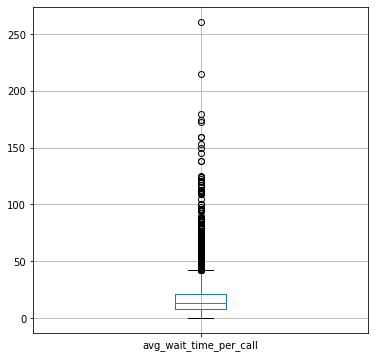

In [40]:
outer_incoming_calls.boxplot(column='avg_wait_time_per_call', figsize=(6,6))

(0, 43)

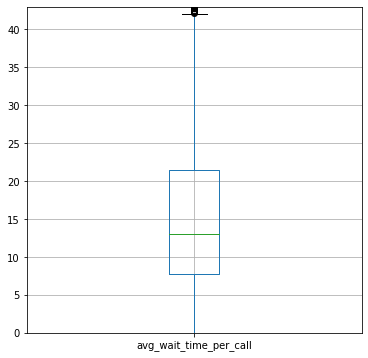

In [41]:
outer_incoming_calls.boxplot(column='avg_wait_time_per_call', figsize=(6,6))
plt.ylim(0, 43)

In [42]:
np.percentile(outer_incoming_calls['avg_wait_time_per_call'], [95])

array([40.5])

In [43]:
outer_incoming_calls = outer_incoming_calls.query('avg_wait_time_per_call <= avg_wait_time_per_call.quantile(0.95)')
outer_incoming_calls['avg_wait_time_per_call'].describe()

count    12867.000000
mean        14.509734
std          9.012814
min          0.000000
25%          7.500000
50%         12.333333
75%         20.000000
max         40.500000
Name: avg_wait_time_per_call, dtype: float64

Text(0.5, 1.0, 'Время ожидания входящих внешних вызовов')

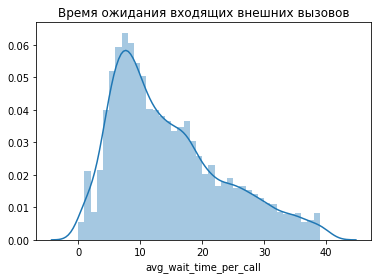

In [104]:
sns.distplot(outer_incoming_calls['avg_wait_time_per_call'],  norm_hist=True, bins = range(40))
plt.title('Время ожидания входящих внешних вызовов')

In [45]:
np.percentile(outer_incoming_calls['avg_wait_time_per_call'], [55, 60])

array([13.75, 15.  ])


По очищенным данным:
    
среднее время ожидания у входящего внешнего звонка - 14,5 секунды
    
у 25% входящих внешних звонков время ожидания составило - 7.5 секунды
    
у 50% входящих внешних звонков время ожидания составило - 12,3 секунды
    
у 75% входящих внешних звонков время ожидания составило - 20 секунд
        
Выбросы были от 40,5 до 261 секунды
    
    
*Сделаем порог в **15 секунд**, после которого время ожидания будет считаться высоким. Соответственно, операторы отвечающие на внешний входящий звонок, более 15 секунд будут считаться не эффективными.*


In [46]:
check_incoming_calls = outer_incoming_calls.groupby('operator_id')['avg_wait_time_per_call'].mean().reset_index()
check_incoming_calls.head()

,operator_id,avg_wait_time_per_call
0,879896.0,11.378190
1,879898.0,10.385278
2,880020.0,7.250000
3,880022.0,14.000000
4,880026.0,5.991228



    
**Функция, определяющая операторов, которые отвечают на звонки более 15 секунд**

In [47]:
def check_avg_wait_time_per_call(avg_wait_time_per_call):
    if avg_wait_time_per_call > 15:
        return 'не эффективно'
    else:
        return 'в допуске'
 
check_incoming_calls['check'] = check_incoming_calls['avg_wait_time_per_call'].apply(check_avg_wait_time_per_call)

In [48]:
check_incoming_calls.head(10)

,operator_id,avg_wait_time_per_call,check
0,879896.0,11.378190,в допуске
1,879898.0,10.385278,в допуске
2,880020.0,7.250000,в допуске
3,880022.0,14.000000,в допуске
4,880026.0,5.991228,в допуске
5,880028.0,6.304444,в допуске
6,882476.0,15.500000,не эффективно
7,882478.0,13.000000,в допуске
8,882680.0,15.218699,не эффективно
9,882684.0,15.998179,не эффективно


### 2.3. Исследовать долю пропущенных звонков по операторам. На основе исследования распределения данных выявить критерии определения неэффективных операторов. Определить порог после которого, число пропущенных входящих вызовов будет считаться большим.<a class="anchor" id="2-3-bullet"></a>

In [49]:
telecom_dataset['is_missed_call'].value_counts()

0    30153
1    15517
Name: is_missed_call, dtype: int64


    В датасете 66,02% - принятых звонков и 33,98% не принятых звонков.

In [50]:
telecom_dataset['date'].describe()

count                   45670
unique                    118
top       2019-11-25 00:00:00
freq                     1083
first     2019-08-02 00:00:00
last      2019-11-28 00:00:00
Name: date, dtype: object

    Данные взяты с 2019-08-02 по 2019-11-28 за 119 календарных дня. Брать общее количество пропущенных звонков
    по операторам и сравнивать их не корректно, так как операторы работали разное количество дней. Поэтому для каждого
    оператора будет посчитаны пропущенные звонки за каждый день и выведено среднее количество пропущенных за день.

In [51]:
telecom_missed_call = telecom_dataset[telecom_dataset['is_missed_call'] == 1].reset_index()
telecom_missed_call.head()

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call
0,1,166377,2019-08-05,out,1,880022.0,1,3,0,5,5,1.666667
1,2,166377,2019-08-05,out,1,880020.0,1,1,0,1,1,1.000000
2,4,166377,2019-08-05,out,0,880022.0,1,3,0,25,25,8.333333
3,6,166377,2019-08-05,out,0,880020.0,1,8,0,50,50,6.250000
4,8,166377,2019-08-05,out,0,880020.0,1,8,0,50,50,6.250000


In [52]:
cnt_missed_call = telecom_missed_call.groupby(['operator_id', 'date'])['calls_count'].mean().reset_index()
cnt_missed_call.head()

,operator_id,date,calls_count
0,879896.0,2019-08-02,8.0
1,879896.0,2019-08-03,7.0
2,879896.0,2019-08-04,1.0
3,879896.0,2019-08-05,1.0
4,879896.0,2019-08-06,4.0


In [53]:
cnt_missed_call['calls_count'].describe()

count    12321.000000
mean        20.053187
std         76.380174
min          1.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       4817.000000
Name: calls_count, dtype: float64


Среднее количество пропущенных звонков в день у операторов - 20
    
Стандартная ошибка - 76.38 говорит о сильных выбросах и аномалиях.
    
25% операторов пропускают до 2 звонков в день.
    
у 50% операторов количество пропущенных звонков не превысило 5-ти
    
у 75% операторов количество пропущенных звонков не превысило 16-ти
    
максимальный выброс - 4817 пропущенных звонков. Если у оператора 12 часовой рабочий день, он должен был пропускать звонок каждые 9 секунд, что является не возможным.
    
Посмотрим на диаграмму размаха

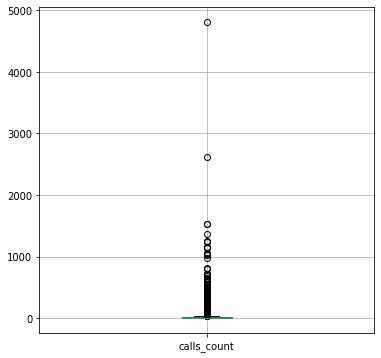

In [54]:
cnt_missed_call.boxplot(column='calls_count', figsize=(6,6))

(0, 37.5)

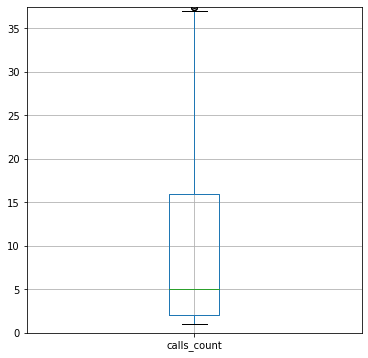

In [55]:
cnt_missed_call.boxplot(column='calls_count', figsize=(6,6))
plt.ylim(0, 37.5)

In [56]:
cnt_missed_call_cor = cnt_missed_call.query('calls_count <= calls_count.quantile(0.95)')
cnt_missed_call_cor['calls_count'].describe()

count    11711.000000
mean        10.809209
std         14.855648
min          1.000000
25%          2.000000
50%          4.000000
75%         13.000000
max         74.000000
Name: calls_count, dtype: float64

Text(0.5, 1.0, 'Количество пропущенных звонков в день')

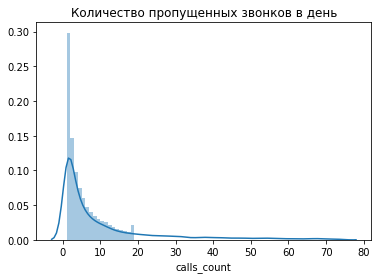

In [107]:
sns.distplot(cnt_missed_call_cor['calls_count'], norm_hist=True, bins = range(20))
plt.title('Количество пропущенных звонков в день')

In [58]:
np.percentile(cnt_missed_call_cor['calls_count'], [55, 60])

array([5., 7.])


    
**По очищенным данным**
    
Большинство значений находятся в диапозоне от 0 до 5
    
Среднее количество пропущенных звонка в день у операторов - 10,81
        
25% операторов пропускают до 2 звонков в день.
    
у 50% операторов количество пропущенных звонков не превысило 4-ех
    
у 75% операторов количество пропущенных звонков не превысило 13-ти
    
максимальное количество пропущенных звонков - 74
    
*Сделаем порог в **6 звонков**, после которого количество пропущенных звонков будет считаться большим. Соответственно, операторы, пропускающие 5 звонков в день, будут считаться не эффективными.*


    
**Функция, определяющая операторов, которые пропускают более 5 звонков в день**

In [59]:
def cnt_missed_call(calls_count):
    if calls_count > 6:
        return 'не эффективно'
    else:
        return 'в допуске'
 
cnt_missed_call_cor['check'] = cnt_missed_call_cor['calls_count'].apply(cnt_missed_call)

In [60]:
cnt_missed_call_cor.head()

,operator_id,date,calls_count,check
0,879896.0,2019-08-02,8.0,не эффективно
1,879896.0,2019-08-03,7.0,не эффективно
2,879896.0,2019-08-04,1.0,в допуске
3,879896.0,2019-08-05,1.0,в допуске
4,879896.0,2019-08-06,4.0,в допуске


### 2.4. Исследовать количество исходящих звонков. На основе исследования распределения данных выявить критерии определения неэффективных операторов. Определить порог до которого, число исходящих вызовов будет считаться не достаточным.<a class="anchor" id="2-4-bullet"></a>

In [61]:
outgoing_calls = telecom_dataset[telecom_dataset['direction'] == "out"].reset_index()
outgoing_calls.head(5)

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call
0,1,166377,2019-08-05,out,1,880022.0,1,3,0,5,5,1.666667
1,2,166377,2019-08-05,out,1,880020.0,1,1,0,1,1,1.000000
2,3,166377,2019-08-05,out,1,880020.0,0,1,10,18,8,8.000000
3,4,166377,2019-08-05,out,0,880022.0,1,3,0,25,25,8.333333
4,5,166377,2019-08-05,out,0,880020.0,0,2,3,29,26,13.000000


In [62]:
cnt_outgoing_calls_per_day = outgoing_calls.groupby(['operator_id', 'date'])['calls_count'].mean().reset_index()
cnt_outgoing_calls_per_day

,operator_id,date,calls_count
0,879896.0,2019-08-02,4.333333
1,879896.0,2019-08-03,5.000000
2,879896.0,2019-08-04,1.000000
3,879896.0,2019-08-05,9.333333
4,879896.0,2019-08-06,16.200000
...,...,...,...
15108,972412.0,2019-11-27,13.000000
15109,972412.0,2019-11-28,17.000000
15110,972460.0,2019-11-27,2.750000
15111,972460.0,2019-11-28,19.000000


In [63]:
cnt_outgoing_calls_per_day['calls_count'].describe()

count    15113.000000
mean        19.496696
std         62.646601
min          1.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       2511.000000
Name: calls_count, dtype: float64

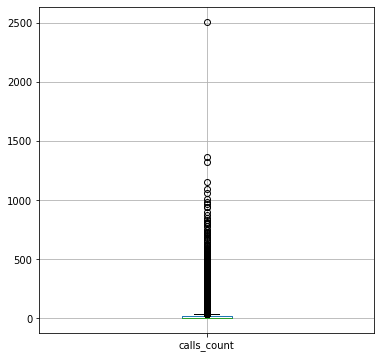

In [64]:
cnt_outgoing_calls_per_day.boxplot(column='calls_count', figsize=(6,6))


Среднее значение по выборке - 19 звонков
    
Стандартное отклонение - 62,7 говорит нам об анамалиях и выбросах.
    
25% операторов совершают не более 2ух звонков в день
    
25% операторов совершают не более 5 звонков в день
    
25% операторов совершают не более 16 звонков в день
    
максимальный выброс - 2511 звонков. Предположим, что у оператора 12 часовой рабочий день. Чтобы совершить такое количество звонков, он должен без перерыва совершать звонок через каждые 3 секунды. Данная цифра анамально.
    
Приблизим boxplot, чтобы посмотреть, где заканчиваются нормальные значения и начинаются выбросы.


(0, 37.5)

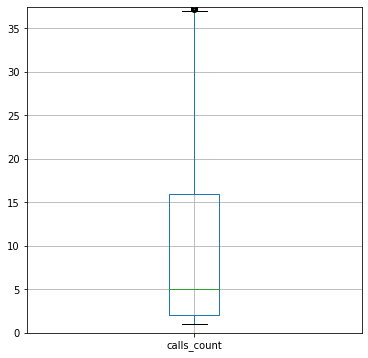

In [65]:
cnt_outgoing_calls_per_day.boxplot(column='calls_count', figsize=(6,6))
plt.ylim(0,37.5)

In [66]:
cnt_outgoing_calls_per_day_cor = cnt_outgoing_calls_per_day.query('calls_count <= calls_count.quantile(0.95)')
cnt_outgoing_calls_per_day_cor['calls_count'].describe()

count    14362.000000
mean        10.624050
std         13.949063
min          1.000000
25%          2.000000
50%          4.500000
75%         13.333333
max         69.500000
Name: calls_count, dtype: float64

Text(0.5, 1.0, 'Количество исходящих звонков в день')

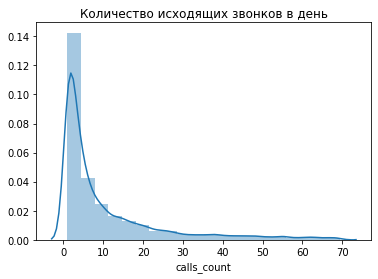

In [67]:
sns.distplot(cnt_outgoing_calls_per_day_cor['calls_count'], bins=20)
plt.title('Количество исходящих звонков в день')

In [68]:
np.percentile(cnt_outgoing_calls_per_day_cor['calls_count'], [55, 60, 62])

array([5.5       , 6.75      , 7.33333333])


    
По очищенным данным:
    
Большинство значений находится в диапозоне от 1 до 5
    
Среднее значение по выборке - 10,62 исходящих звонков в день

25% операторов совершают не более 2ух звонков в день

50% операторов совершают не более 4,5 звонков в день

75% операторов совершают не более 13,3 звонков в день
    
максимальное количество звонков в день - 69,5
    
*Сделаем порог в **7 звонков**, до которого количество исходящих звонков будет считаться не достаточным. Соответственно, операторы, совершившие менее 6 звонков в день, будут считаться не эффективными.*


    
**Функция, определяющая операторов, у которых количество исходящих звонков меньше 6**

In [69]:
pd.options.mode.chained_assignment = None

In [70]:
def cnt_outgoing_calls(calls_count):
    if calls_count < 7:
        return 'не эффективно'
    else:
        return 'в допуске'
 
cnt_outgoing_calls_per_day_cor['check'] = cnt_outgoing_calls_per_day_cor['calls_count'].apply(cnt_outgoing_calls)

In [71]:
cnt_outgoing_calls_per_day_cor.head()

,operator_id,date,calls_count,check
0,879896.0,2019-08-02,4.333333,не эффективно
1,879896.0,2019-08-03,5.000000,не эффективно
2,879896.0,2019-08-04,1.000000,не эффективно
3,879896.0,2019-08-05,9.333333,в допуске
4,879896.0,2019-08-06,16.200000,в допуске


### Шаг 3. Проверка гипотез<a class="anchor" id="3-bullet"></a>

In [72]:
telecom = telecom_dataset.merge(telecom_clients, on='user_id', how='inner')
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call,tariff_plan,date_start
0,166377,2019-08-05,out,1,880022.0,1,3,0,5,5,1.666667,B,2019-08-01
1,166377,2019-08-05,out,1,880020.0,1,1,0,1,1,1.000000,B,2019-08-01
2,166377,2019-08-05,out,1,880020.0,0,1,10,18,8,8.000000,B,2019-08-01
3,166377,2019-08-05,out,0,880022.0,1,3,0,25,25,8.333333,B,2019-08-01
4,166377,2019-08-05,out,0,880020.0,0,2,3,29,26,13.000000,B,2019-08-01


In [73]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 0 to 45669
Data columns (total 13 columns):
user_id                   45670 non-null int64
date                      45670 non-null datetime64[ns]
direction                 45670 non-null object
internal                  45670 non-null int64
operator_id               45670 non-null float64
is_missed_call            45670 non-null int64
calls_count               45670 non-null int64
call_duration             45670 non-null int64
total_call_duration       45670 non-null int64
waiting_time              45670 non-null int64
avg_wait_time_per_call    45670 non-null float64
tariff_plan               45670 non-null object
date_start                45670 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(7), object(2)
memory usage: 4.9+ MB


In [74]:
telecom.groupby('tariff_plan')['user_id'].nunique()

tariff_plan
A     32
B    101
C    157
Name: user_id, dtype: int64


    
В датасете всего 32 уникальных пользователя, которые используют тариф А ( 11,03%)

101 уникальный пользователь использует тариф В (34,83%)
    
157 уникальный пользователь использует тариф С (54.14%) 

### 3.1. Проверка гипотезы о различии времени ожидания ответа на входящий звонок в зависимости от тарифного плана<a class="anchor" id="3-1-bullet"></a>

In [75]:
telecom_avg_time = telecom.query('avg_wait_time_per_call <= 42')
telecom_avg_time.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call,tariff_plan,date_start
0,166377,2019-08-05,out,1,880022.0,1,3,0,5,5,1.666667,B,2019-08-01
1,166377,2019-08-05,out,1,880020.0,1,1,0,1,1,1.000000,B,2019-08-01
2,166377,2019-08-05,out,1,880020.0,0,1,10,18,8,8.000000,B,2019-08-01
3,166377,2019-08-05,out,0,880022.0,1,3,0,25,25,8.333333,B,2019-08-01
4,166377,2019-08-05,out,0,880020.0,0,2,3,29,26,13.000000,B,2019-08-01


In [76]:
sample_A = telecom_avg_time[telecom_avg_time['tariff_plan'] == 'A']['avg_wait_time_per_call'].reset_index()
sample_A['avg_wait_time_per_call'].describe()

count    13078.000000
mean        16.158125
std          9.269104
min          0.000000
25%          8.717532
50%         16.000000
75%         22.000000
max         42.000000
Name: avg_wait_time_per_call, dtype: float64

In [77]:
sample_B = telecom_avg_time[telecom_avg_time['tariff_plan'] == 'B']['avg_wait_time_per_call'].reset_index()
sample_B['avg_wait_time_per_call'].describe()

count    15239.000000
mean        15.591886
std          9.485725
min          0.000000
25%          9.000000
50%         14.000000
75%         20.800000
max         42.000000
Name: avg_wait_time_per_call, dtype: float64

In [78]:
sample_С = telecom_avg_time[telecom_avg_time['tariff_plan'] == 'C']['avg_wait_time_per_call'].reset_index()
sample_С['avg_wait_time_per_call'].describe()

count    15934.000000
mean        14.411680
std          9.025517
min          0.000000
25%          7.500000
50%         13.545455
75%         19.500000
max         42.000000
Name: avg_wait_time_per_call, dtype: float64


    
Посмотрим на график, который характеризует форму распределения

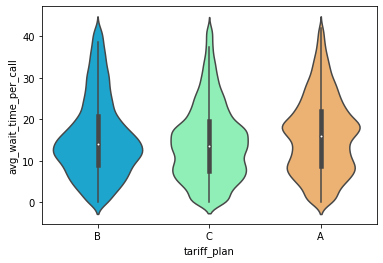

In [79]:
sns.violinplot(x="tariff_plan", y="avg_wait_time_per_call", data=telecom_avg_time, palette='rainbow');


    
Медиана в тарифе В (14 сек.) и С (13.5 сек) находится приблизительно на одном уровне, в тарифе А выше (16 сек).
    
Первый квартиль в тарифе С (7,5 сек) ниже, чем в тарифе А (8.7 сек) и В (9 сек)
    
Третий квартиль в тарифе С ниже (19,5 сек), чем в тарифе А (22 сек) и В (20 сек)
    
В тарифе В - один пик. Большинство данных собраны в районе 13 секунд
    
В трафике С - два пика. Большинство данных собраны в районе 8 и 16 секунд
    
В трафике А - два пика. Большинство данных собраны в районе 9 и 18 секунд
    
**По текущим данным быстрее всех отвечают операторы на тарифе С, потом В. Медленнее отвечают операторы на тарифе А**
    
Проверим гипотезу о разнице между тарифами при помощи стат.значимости


    
***Нулевая Гипотеза*** - нет статистически значимой разницы между тарифами по времени ожидания ответа на входящий звонок 
    
***Альтернативная гипотеза*** - существует статистически значимая разница между разными тарифами по времени ожидания ответа на входящий звонок.

**Непараметрический тест Уилкоксона-Манна-Уитни**

***тест устойчив к выбросам и анамалиям***

    Непараметрических метод заключается том, что он работает с рангами, — номерами значений   в   упорядоченном ряду, —     никак не учитывая сами значения. Поэтому к ним прибегаем тогда, когда работа с самими значениями невозможна из-за       выбросов, сильно сдвигающих параметрические результаты.
    В исследовательскому анализе данных были обнаружены выбросы и анамалии в данных.

In [80]:
sample_A = telecom[telecom['tariff_plan'] == 'A']['avg_wait_time_per_call']
sample_B = telecom[telecom['tariff_plan'] == 'B']['avg_wait_time_per_call']
sample_C = telecom[telecom['tariff_plan'] == 'C']['avg_wait_time_per_call']

***Функция для проведения теста Уилкоксона-Манна-Уитни***

In [81]:
def mannwhitneyu_test(a, b, c):
    alpha = .05
    results_AB_mannwhitneyu = st.mannwhitneyu(sample_A, sample_B)
    results_BC_mannwhitneyu = st.mannwhitneyu(sample_B, sample_C)
    results_AC_mannwhitneyu = st.mannwhitneyu(sample_A, sample_C)
    print('p-значение для сравнения групп А и B: ', results_AB_mannwhitneyu.pvalue)
    print('p-значение для сравнения групп B и C: ', results_BC_mannwhitneyu.pvalue)
    print('p-значение для сравнения групп А и C: ', results_AC_mannwhitneyu.pvalue)
    if (results_AB_mannwhitneyu.pvalue < alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов А и B, вывод о различии сделать нельзя")

    if (results_BC_mannwhitneyu.pvalue < alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов B и C, вывод о различии сделать нельзя")

    if (results_AC_mannwhitneyu.pvalue < alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов А и C, вывод о различии сделать нельзя")

In [82]:
mannwhitneyu_test(sample_A, sample_B, sample_C)

p-значение для сравнения групп А и B:  2.3552090724152685e-07
p-значение для сравнения групп B и C:  3.3747251947516817e-31
p-значение для сравнения групп А и C:  7.228678215357944e-63
Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима


### 3.2. Проверка гипотезы о различии числа пропущенных входящих вызовов в зависимости от тарифного плана.<a class="anchor" id="3-2-bullet"></a>

In [83]:
telecom_missed_call = telecom[telecom['is_missed_call'] == 1].reset_index()
telecom_missed_call.head()

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call,tariff_plan,date_start
0,0,166377,2019-08-05,out,1,880022.0,1,3,0,5,5,1.666667,B,2019-08-01
1,1,166377,2019-08-05,out,1,880020.0,1,1,0,1,1,1.000000,B,2019-08-01
2,3,166377,2019-08-05,out,0,880022.0,1,3,0,25,25,8.333333,B,2019-08-01
3,5,166377,2019-08-05,out,0,880020.0,1,8,0,50,50,6.250000,B,2019-08-01
4,6,166377,2019-08-05,out,0,880020.0,1,8,0,50,50,6.250000,B,2019-08-01


In [84]:
telecom_missed_call = telecom_missed_call.groupby(['tariff_plan', 'date'])['calls_count'].sum().reset_index()
telecom_missed_call.head()

,tariff_plan,date,calls_count
0,A,2019-08-12,332
1,A,2019-08-13,370
2,A,2019-08-14,417
3,A,2019-08-15,382
4,A,2019-08-16,515


(0, 2600)

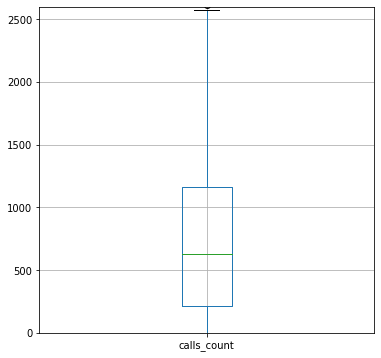

In [85]:
telecom_missed_call.boxplot(column='calls_count', figsize=(6,6))
plt.ylim(0,2600)

In [86]:
telecom_missed_call_cor = telecom_missed_call.query('calls_count <= 2600')

In [87]:
sample_A = telecom_missed_call_cor[telecom_missed_call_cor['tariff_plan'] == 'A'].reset_index()
sample_A['calls_count'].describe()

count      89.000000
mean     1180.820225
std       717.061674
min       132.000000
25%       595.000000
50%      1059.000000
75%      1729.000000
max      2576.000000
Name: calls_count, dtype: float64

In [88]:
sample_B = telecom_missed_call_cor[telecom_missed_call_cor['tariff_plan'] == 'B'].reset_index()
sample_B['calls_count'].describe()

count     118.000000
mean      403.525424
std       370.013992
min         1.000000
25%        98.250000
50%       302.500000
75%       616.750000
max      1213.000000
Name: calls_count, dtype: float64

In [89]:
sample_C = telecom_missed_call_cor[telecom_missed_call_cor['tariff_plan'] == 'C'].reset_index()
sample_C['calls_count'].describe()

count     104.000000
mean      669.903846
std       570.339679
min         1.000000
25%       161.000000
50%       608.500000
75%       946.750000
max      2365.000000
Name: calls_count, dtype: float64

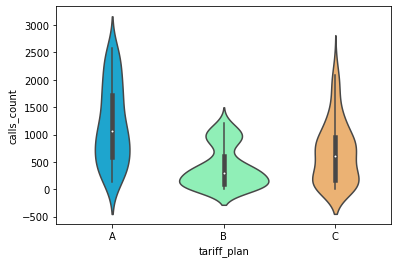

In [90]:
sns.violinplot(x="tariff_plan", y="calls_count", data=telecom_missed_call_cor, palette='rainbow');


    
Медиана в тарифе А (1059 звонков)значительно выше, чем в тарифе С (608,5 зв.). Медиана в тарифе С выше, чем в тарифе В (302,5 звонков)
    
Первый квартиль в тарифе А (595 зв.) значительно выше, чем в тарифе С (161 зв.). Первый квартиль в тарифе С выше, чем в тарифе В (98,3 зв.)
    
Третий квартиль в тарифе А (1729 зв.) значительно выше, чем в тарифе С (946,75). Третий квартиль в тарифе С выше, чем в тарифе В (616,8 зв.)
    
В тарифе В - один значительный пик. Большинство данных собраны в районе 100 звонков. Далее есть не значительный пик в районе 1000 звонков. Максимальное значение - 1213
    
В трафике С - два пика. Большинство данных собраны в районе 100 и 800 звонков. Максимальное количество 2365
    
В трафике А - нет значительных пиков.
Максимальное количество 2576
    
**По текущим данным меньше всего пропускают входящие звонки операторы на тарифе В, потом С.Больше всего не отвеченных звонков у операторов на тарифе А**
    
Проверим гипотезу о разнице между тарифами при помощи стат.значимости
    




***Нулевая Гипотеза*** - нет статистически значимой разницы между тарифами по числу пропущенных входящих вызовов 
    
***Альтернативная гипотеза*** - существует статистически значимая разница между разными тарифами по числу пропущенных входящих вызовов

**Непараметрический тест Уилкоксона-Манна-Уитни**


In [91]:
sample_A = telecom_missed_call[telecom_missed_call['tariff_plan'] == 'A']['calls_count']
sample_B = telecom_missed_call[telecom_missed_call['tariff_plan'] == 'B']['calls_count']
sample_C = telecom_missed_call[telecom_missed_call['tariff_plan'] == 'C']['calls_count']

In [92]:
mannwhitneyu_test(sample_A, sample_B, sample_C)

p-значение для сравнения групп А и B:  1.4387176727598636e-21
p-значение для сравнения групп B и C:  0.0004035037572698628
p-значение для сравнения групп А и C:  1.186758321924151e-10
Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима


### 3.3. Проверка гипотезы о различии числа исходящих вызовов в зависимости от тарифного плана.<a class="anchor" id="3-3-bullet"></a>

In [93]:
telecom_outgoing_calls = telecom[telecom['direction'] == "out"].reset_index()
telecom_outgoing_calls.head(5)

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call,tariff_plan,date_start
0,0,166377,2019-08-05,out,1,880022.0,1,3,0,5,5,1.666667,B,2019-08-01
1,1,166377,2019-08-05,out,1,880020.0,1,1,0,1,1,1.000000,B,2019-08-01
2,2,166377,2019-08-05,out,1,880020.0,0,1,10,18,8,8.000000,B,2019-08-01
3,3,166377,2019-08-05,out,0,880022.0,1,3,0,25,25,8.333333,B,2019-08-01
4,4,166377,2019-08-05,out,0,880020.0,0,2,3,29,26,13.000000,B,2019-08-01


In [94]:
telecom_outgoing_calls = telecom_outgoing_calls.groupby(['tariff_plan', 'date'])['calls_count'].sum().reset_index()
telecom_missed_call.head()

,tariff_plan,date,calls_count
0,A,2019-08-12,332
1,A,2019-08-13,370
2,A,2019-08-14,417
3,A,2019-08-15,382
4,A,2019-08-16,515


(0, 6100)

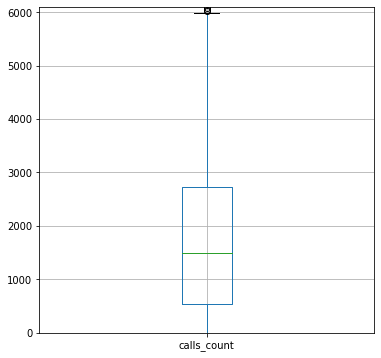

In [95]:
telecom_outgoing_calls.boxplot(column='calls_count', figsize=(6,6))
plt.ylim(0,6100)

In [96]:
telecom_outgoing_calls_cor = telecom_outgoing_calls.query('calls_count <= 6000')

In [97]:
sample_A = telecom_outgoing_calls_cor[telecom_outgoing_calls_cor['tariff_plan'] == 'A']['calls_count'].reset_index()
sample_A['calls_count'].describe()

count      91.000000
mean     2783.153846
std      1611.440059
min       268.000000
25%      1477.500000
50%      2506.000000
75%      3906.500000
max      5980.000000
Name: calls_count, dtype: float64

In [98]:
sample_B = telecom_outgoing_calls_cor[telecom_outgoing_calls_cor['tariff_plan'] == 'B']['calls_count'].reset_index()
sample_B['calls_count'].describe()

count     118.000000
mean     1027.466102
std       919.611045
min         2.000000
25%       216.750000
50%       843.000000
75%      1607.000000
max      3043.000000
Name: calls_count, dtype: float64

In [99]:
sample_C = telecom_outgoing_calls_cor[telecom_outgoing_calls_cor['tariff_plan'] == 'C']['calls_count'].reset_index()
sample_C['calls_count'].describe()

count     107.000000
mean     1450.719626
std      1198.183954
min         1.000000
25%       334.500000
50%      1404.000000
75%      2225.500000
max      4923.000000
Name: calls_count, dtype: float64

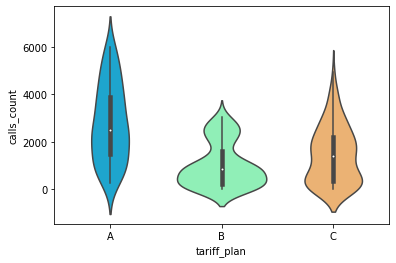

In [100]:
sns.violinplot(x="tariff_plan", y="calls_count", data=telecom_outgoing_calls_cor, palette='rainbow');


    
Медиана в тарифе А (2506 звонков) значительно выше, чем в тарифе С (1404 зв.). Медиана в тарифе С выше, чем в тарифе В (843 зв.)
    
Первый квартиль в тарифе А (1477,5 зв.) значительно выше, чем в тарифе С (334,5 зв.). Первый квартиль в тарифе С выше, чем в тарифе В (216,75 зв.)
    
Третий квартиль в тарифе А (3906 зв.) значительно выше, чем в тарифе С (2225,5 зв.). Третий квартиль в тарифе С выше, чем в тарифе В (1607 зв.)
    
В тарифе В - один значительный пик. Большинство данных собраны в районе 425 звонков. Далее есть не значительный пик в районе 2550 звонков. Максимальное значение - 3043
    
В трафике С - два пика. Большинство данных собраны в районе 300 и 2000 звонков. Максимальное количество 4329
    
В трафике А - нет значительных пиков.
Максимальное количество 5980
    
**По текущим данным операторы тарифа А совершают больше всего исходящих звонков, потом на тарифе С. Меньше всего исходящих звонков у операторов на тарифе В**
    
Проверим гипотезу о разнице между тарифами при помощи стат.значимости



***Нулевая Гипотеза*** - нет статистически значимой разницы между тарифами по числу исходящих вызовов 
    
***Альтернативная гипотеза*** - существует статистически значимая разница между разными тарифами по исходящих вызовов

**Непараметрический тест Уилкоксона-Манна-Уитни**


In [101]:
sample_A = telecom_outgoing_calls[telecom_outgoing_calls['tariff_plan'] == 'A']['calls_count']
sample_B = telecom_outgoing_calls[telecom_outgoing_calls['tariff_plan'] == 'B']['calls_count']
sample_C = telecom_outgoing_calls[telecom_outgoing_calls['tariff_plan'] == 'C']['calls_count']

In [102]:
mannwhitneyu_test(sample_A, sample_B, sample_C)

p-значение для сравнения групп А и B:  1.426769856884665e-20
p-значение для сравнения групп B и C:  0.010973532139469387
p-значение для сравнения групп А и C:  6.575909670210996e-13
Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима


### Шаг 4. Выводы и рекомендации<a class="anchor" id="4-bullet"></a>


    
**1. Количество операторов у клиентов:**    
  
* У 50% клиентов не более 2ух операторов;    
* у 75% клиентов не больше 4 операторов.
    
**2. Могут ли операторы работать с исходящими и входящими звонками:**
    
* 49,82% операторов работают как с исходящими, так и с входящими звонками.
* 50,18% операторов работают только с одной группой звонков.
    
**3. Критерий определения неэффективных операторов - время ожидания ответа на входящий внешний звонок**
    
Определен порог в **15 секунд**, после которого время ожидания будет считаться высоким. Соответственно, операторы отвечающие на внешний входящий звонок, более 15 секунд будут считаться не эффективными.
    
**4. Критерий определения неэффективных операторов - количество пропущенных звонков**
    
Определен порог в **6 звонков**, после которого количество пропущенных звонков будет считаться большим. Соответственно, операторы, пропускающие более 5 звонков в день, будут считаться не эффективными.
    
**5.  Критерий определения неэффективных операторов - количество исходящих звонков**
    
Определен порог в **7 звонков**, до которого количество исходящих звонков будет считаться не достаточным. Соответственно, операторы, совершившие менее 6 звонков в день, будут считаться не эффективными.
    
**6. Проверка гипотез**
    
**6.1. Проверка гипотезы о различии времени ожидания ответа на входящий звонок в зависимости от тарифного плана**
    
    Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
    Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
    Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима
    
*По текущим данным быстрее всех отвечают операторы на тарифе С, потом В. Медленнее отвечают операторы на тарифе А*
    
**6.2. Проверка гипотезы о различии числа пропущенных входящих вызовов в зависимости от тарифного плана.**
    
    Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
    Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
    Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима
    
*По текущим данным меньше всего пропускают входящие звонки операторы на тарифе В, потом С.Больше всего не
отвеченных звонков у операторов на тарифе А*
    
**6.3. Проверка гипотезы о различии числа исходящих вызовов в зависимости от тарифного плана.**
    
    Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
    Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
    Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима
    
*По текущим данным операторы тарифа А совершают больше всего исходящих звонков, потом на тарифе С. Меньше всего исходящих звонков у операторов на тарифе В*
    
**Общий вывод по операторам**
    
* Операторы тарифа **А** ориентированы на исходящие звонки. По данному критерию в этой группе лучший показателей. По входящим звонкам у операторов тарифа А худшие показатели по обоим критериям: время ожидания ответа и количество пропущенных звонков.
    
    
* Операторы тарифа **В** ориентированы на входящие звонки. Лучший показатель по критерию "число пропущенных звонков", второе место по показателю "время ожидания ответа". Зато по критерию "количесто исходящих звонков" показали худший результат.
    
    
* Операторы тарифа **С** ориентированы как на входящие, так и на исходящие звонки. Второе место по критериям "количество исходящих звонков" и "количество пропущенных звонков". По критерию "время ожидания" заняли первое место
